
📊 [Self-Tuning Preprocessing Configuration]
→ Skewness per feature: [-0.441 -0.2  ]
→ Log transform (per feature): [False, False]
→ ADF p-values: [0.3691 0.4202] → Detrend? ✅
→ Seasonality flags (STL): [np.False_, np.True_]
→ SNR = 0.87 → Apply filter? ✅
→ Missing rate: 0.025 → Imputation: interpolate
→ EWT bands (entropy-based): 3
→ Outlier method: iqr
+---------------------+-------------+
|       Config        |    Value    |
+---------------------+-------------+
|        Shape        |  (200, 2)   |
|       Detrend       |    True     |
| Log Transform (any) |    False    |
|     Imputation      | interpolate |
|      EWT Bands      |      3      |
|       Filter?       |    True     |
|   Outlier Method    |     iqr     |
+---------------------+-------------+
✅ Self-tuning configuration complete.



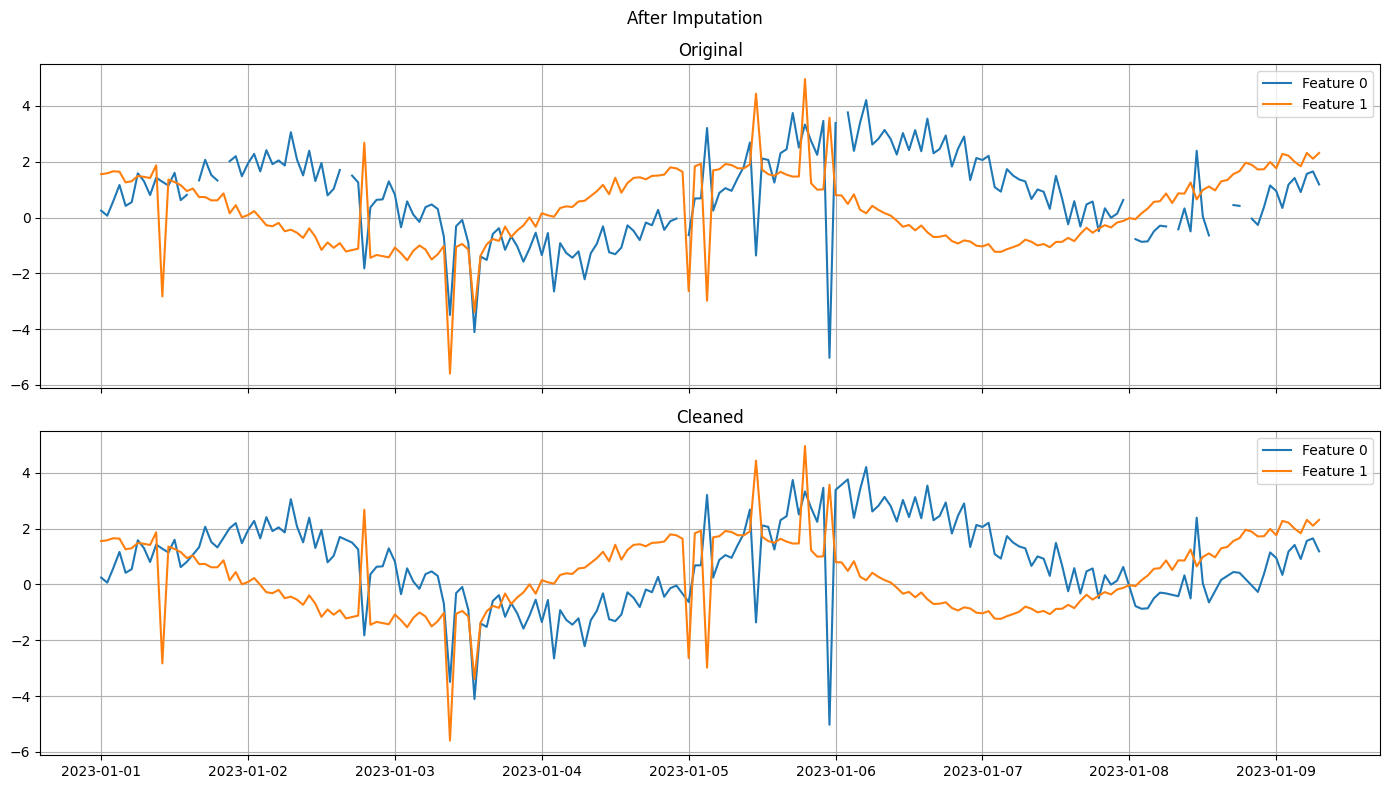

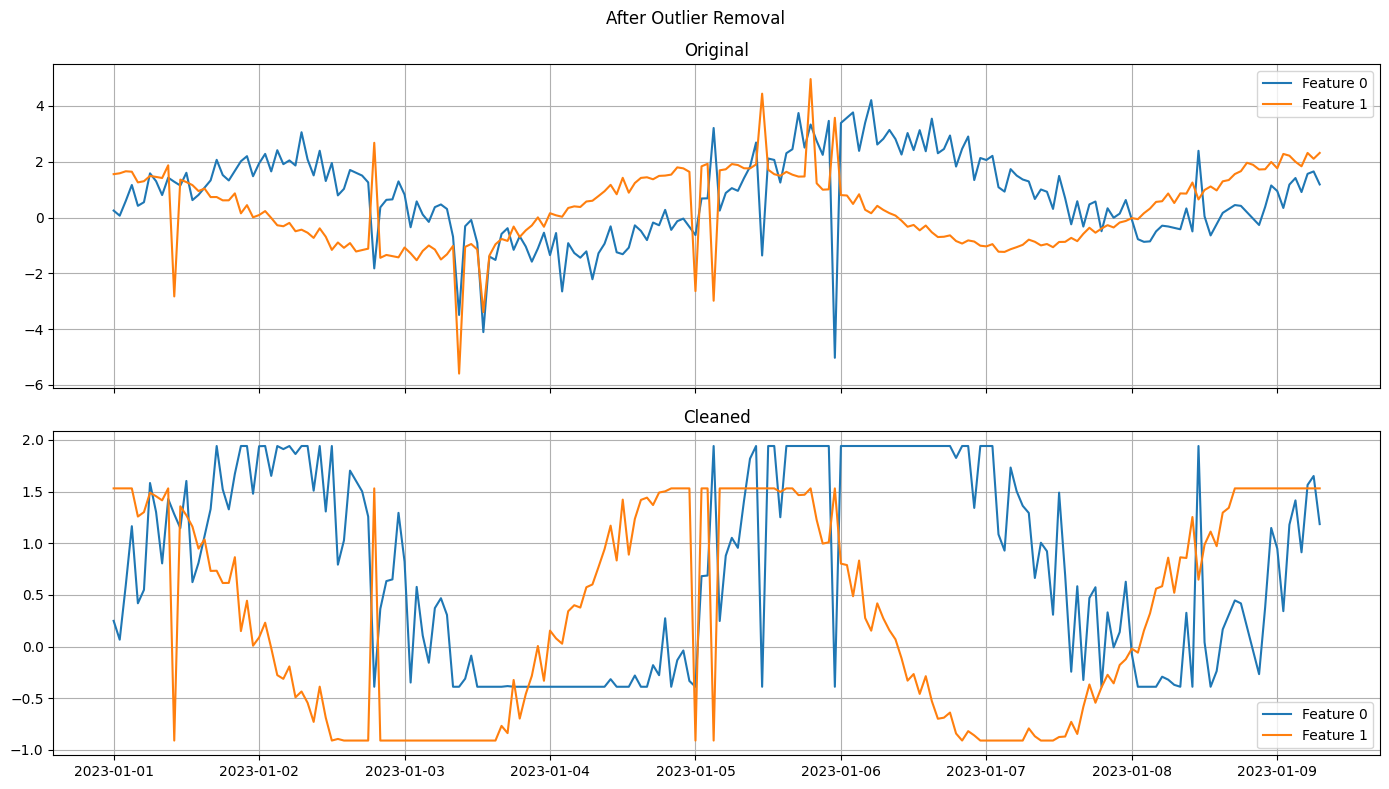

/home/seman/baseline/foreblocks/foreblocks/preprocessing.py:545: UserWarning: PyEWT not installed. Skipping EWT.
  warnings.warn("PyEWT not installed. Skipping EWT.")


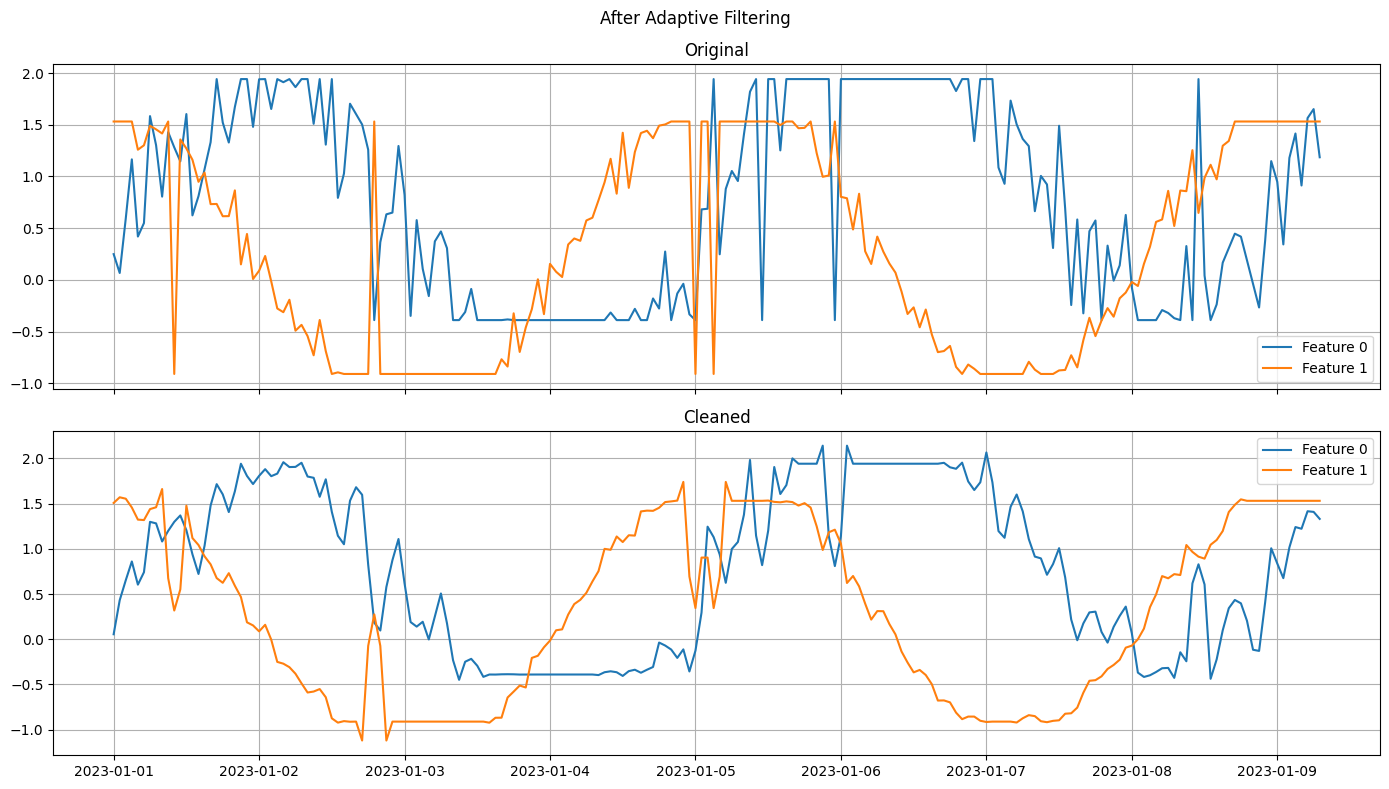

Processed data shape: (200, 2)


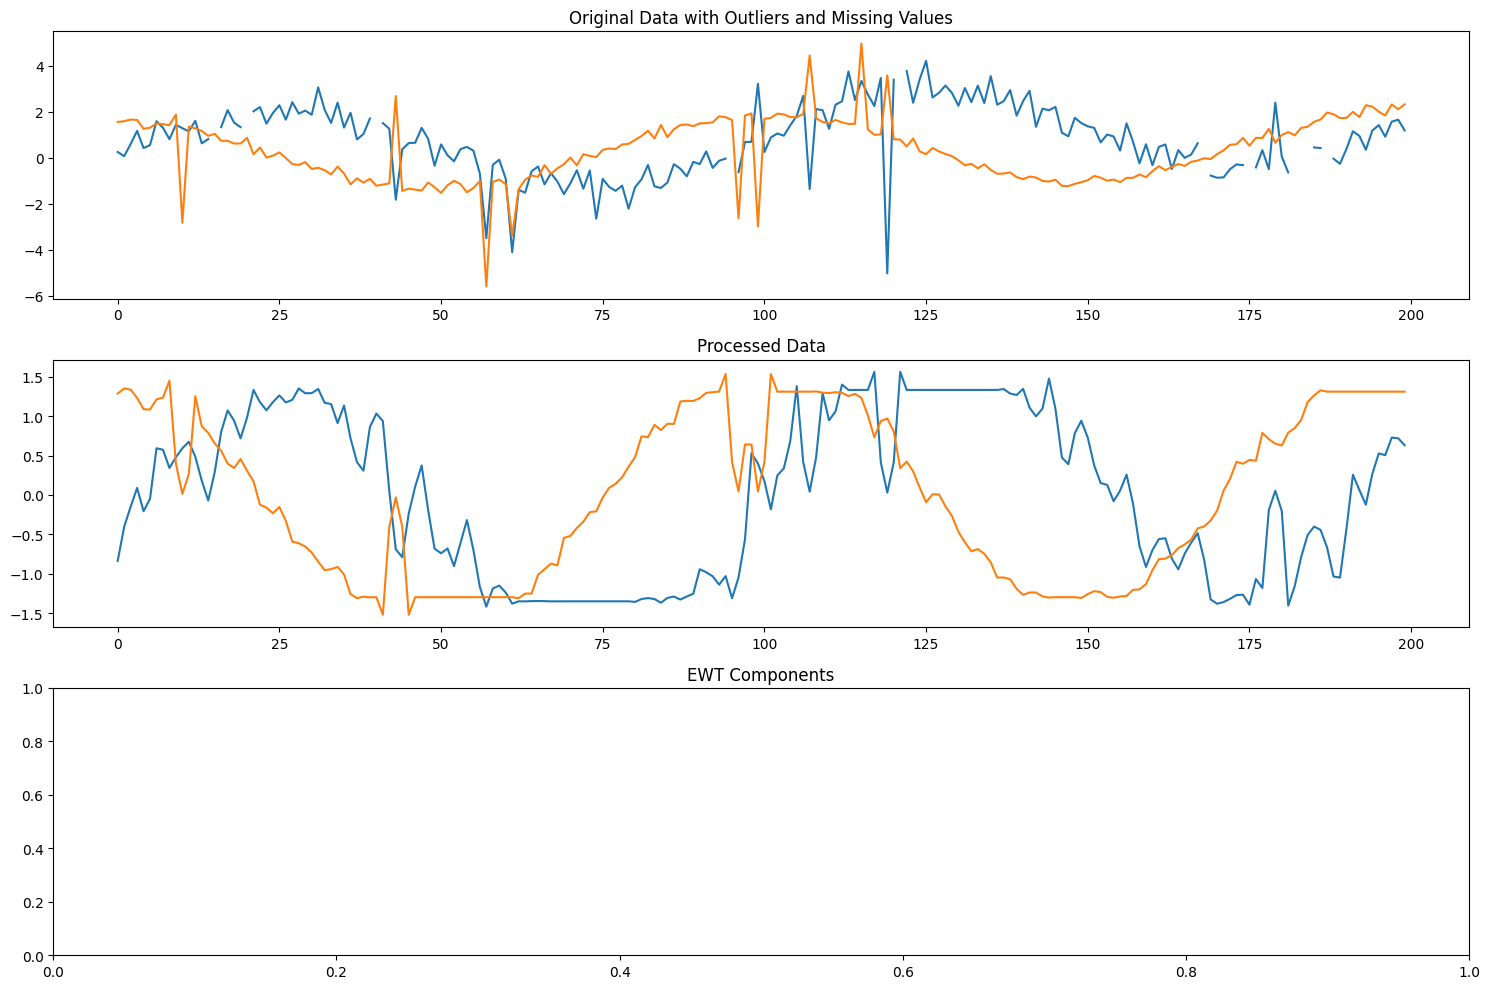

Input sequence shape: (165, 24, 2)
Target sequence shape: (165, 12, 2)


In [7]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from foreblocks import TimeSeriesPreprocessor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='h')

# Create a time series with trend, seasonality, and noise
t = np.linspace(0, 4*np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)  # Daily pattern
seasonality2 = 1 * np.sin(t/24)  # Weekly pattern
noise = np.random.normal(0, 0.5, n_samples)

# Combine components
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# Create a second feature (to demonstrate multivariate capabilities)
data2 = (0.5 * trend + 1.5 * np.cos(t) + 0.5 * np.random.normal(0, 0.3, n_samples)).reshape(-1, 1)
data = np.hstack([data, data2])  # Now we have shape [n_samples, 2]

# Add some outliers
outlier_indices = np.random.choice(n_samples, 10, replace=False)
data[outlier_indices] = data[outlier_indices] + 5 * np.random.randn(10, 2)

# Add some missing values (but not too many)
missing_indices = np.random.choice(n_samples, 10, replace=False)
data[missing_indices, 0] = np.nan  # Only make some values missing in first feature

# Create preprocessor with various techniques enabled
preprocessor = TimeSeriesPreprocessor(
    normalize=True,
    differencing=False,
    detrend=True,
    apply_ewt=True,
    window_size=24,
    horizon=12,
    remove_outliers=True,
    outlier_threshold=0.05,
    outlier_method="iqr",
    impute_method="iterative",
    ewt_bands=5,
    trend_imf_idx=0,
    log_transform=False,
    filter_window=5,
    filter_polyorder=2,
    apply_filter=True,
    self_tune=True,
    apply_imputation=True,
)

# Fit and transform the data
X, y, processed_data = preprocessor.fit_transform(data, time_stamps=timestamps)

# Visualize the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('Original Data with Outliers and Missing Values')
plt.plot(data)

plt.subplot(3, 1, 2)
plt.title('Processed Data')
print("Processed data shape:", processed_data.shape)
plt.plot(processed_data)

plt.subplot(3, 1, 3)
plt.title('EWT Components')
ewt_components = preprocessor.get_ewt_components()
if ewt_components:
    for i, imf in enumerate(ewt_components[0].T):
        plt.plot(imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Input sequence shape: {X.shape}")
print(f"Target sequence shape: {y.shape}")